In [ ]:
#imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
# data preparation and processing

#data is on my google drive and I will download it from there
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def prepare_data(path, image_size = (224,224)):
  arr = []
  for filename in os.listdir(path):
    img_path = os.path.join(path, filename)
    img = Image.open(img_path).convert('RGB')
    img = img.resize(image_size)
    img_array = np.array(img) / 255.0
    arr.append(img_array)
  return np.array(arr)

def displayConfMatrix(model, x_test, y_test):
  y_pred = model.predict(x_test)
  y_pred = np.where(y_pred<0.5, 0, 1)
  ConfusionMatrixDisplay.from_predictions(y_test,y_pred)


def plotData(x, y):
  fig, axes = plt.subplots(2,2)
  idx = np.random.default_rng().integers(0, len(x), (4))
  axes[0,0].imshow(x[idx[0]])

  axes[0,0].set_title(f"Label: {'Malignant' if y[idx[0]] else 'benign'}")

  axes[0,1].imshow(x[idx[1]])
  axes[0,1].set_title(f"Label: {'Malignant' if y[idx[1]] else 'benign'}")

  axes[1,0].imshow(x[idx[2]])
  axes[1,0].set_title(f"Label: {'Malignant' if y[idx[2]] else 'benign'}")

  axes[1,1].imshow(x[idx[3]])
  axes[1,1].set_title(f"Label: {'Malignant' if y[idx[3]] else 'benign'}")

def plotTrainHistory(history):
  fig,ax = plt.subplots(1,2, figsize = (10,5))
  ax[0].plot(history.history['loss'], label = 'train')
  ax[0].plot(history.history['val_loss'], label = 'val')
  ax[0].legend()

  ax[1].plot(history.history['loss'], label = 'train')
  ax[1].plot(history.history['val_loss'], label = 'val')
  ax[1].set_yscale('log')
  ax[1].legend()

In [ ]:
malignant_train = prepare_data('/content/drive/MyDrive/archive/data/train/malignant')
benign_train = prepare_data('/content/drive/MyDrive/archive/data/train/benign')

malignant_test = prepare_data('/content/drive/MyDrive/archive/data/test/malignant')
benign_test = prepare_data('/content/drive/MyDrive/archive/data/test/benign')

malignant_train_label = np.ones(len(malignant_train))
benign_train_label = np.zeros(len(benign_train))

malignant_test_label = np.ones(len(malignant_test))
benign_test_label = np.zeros(len(benign_test))


In [ ]:
x_train = np.concatenate((malignant_train,benign_train), axis = 0)

del(malignant_train) #deleting old datasets, because the session runs out of ram
del(benign_train)
y_train = np.concatenate((malignant_train_label, benign_train_label), axis = 0)

del(malignant_train_label)
del(benign_train_label)
x_test = np.concatenate((malignant_test,benign_test), axis = 0)

del(malignant_test)
del(benign_test)
y_test = np.concatenate((malignant_test_label, benign_test_label), axis = 0)

del(malignant_test_label)
del(benign_test_label)

indices = np.arange(x_train.shape[0])
np.random.shuffle(indices)
x_train = x_train[indices]
y_train = y_train[indices]

indices = np.arange(x_test.shape[0])
np.random.shuffle(indices)
x_test = x_test[indices]
y_test = y_test[indices]


In [ ]:
print(y_train.shape) #2600 labeled pictures for training

(2637,)


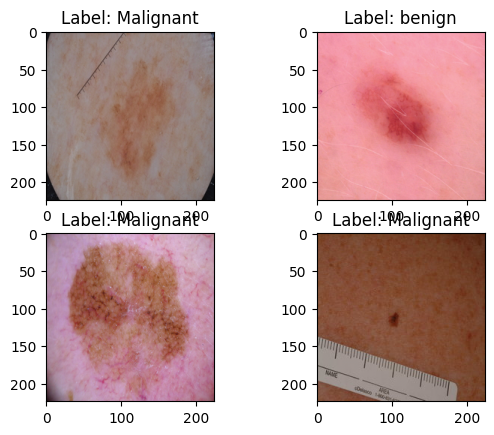

In [ ]:
plotData(x_train, y_train)

In [ ]:
nEpochs = 200

In [ ]:
# 83% accuracy
model = tf.keras.Sequential(layers = [tf.keras.Input(shape=(224,224,3)),
                            #conv block 1
                            tf.keras.layers.Conv2D(64,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(64,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(64,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.MaxPooling2D(2),
                            #conv block 2
                            tf.keras.layers.Conv2D(128,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(128,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(128,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.MaxPooling2D(2),
                            #conv block 3
                            tf.keras.layers.Conv2D(256,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(256,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.Conv2D(256,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.MaxPooling2D(2),
                            tf.keras.layers.Dropout(0.3),
                            #conv block 4
                            tf.keras.layers.Conv2D(256,(3),padding = 'same',activation = 'relu'),
                            tf.keras.layers.MaxPooling2D(2),
                            tf.keras.layers.Dropout(0.3),

                            #fully connected
                            tf.keras.layers.Flatten(),
                            tf.keras.layers.Dense(128,activation = 'relu'),
                            tf.keras.layers.Dropout(0.3),
                            tf.keras.layers.Dense(1, activation = 'sigmoid')
                               ],
                               )

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
      initial_learning_rate=0.001,
      decay_steps=1000,
      decay_rate=0.95,
      staircase=False)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
                  loss=tf.keras.losses.BinaryCrossentropy()
,metrics=['accuracy'])


callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5,min_delta=0.02, verbose=0)

history = model.fit(x=x_train, y=y_train,
                    batch_size=32,
                    epochs=nEpochs,
                    verbose=0,
                    validation_data = (x_test,y_test),
                    callbacks = [callback])

plotTrainHistory(history)

In [ ]:
model.evaluate(x_test,y_test)

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - accuracy: 0.8234 - loss: 0.4398


[0.44016754627227783, 0.8242424130439758]

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step


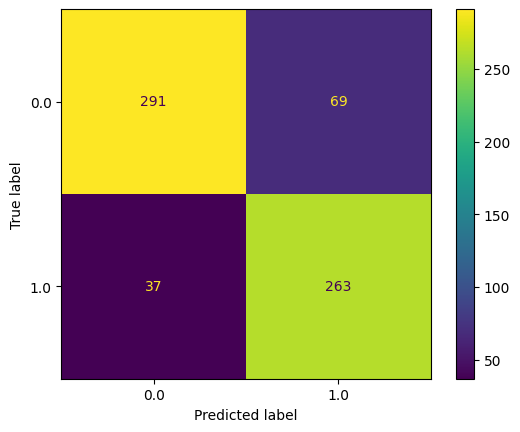

In [ ]:
displayConfMatrix(model,x_test,y_test)